In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

Using TensorFlow backend.


## Step 1: Read data and set column names

In [2]:
df = pd.read_csv('C:\\Users\\mukherjee nildip\\Downloads\\german.data', delim_whitespace=True, header=None)
header = ['StatusCheckingAcc', 'Duration', 'CreditHistory', 'Purpose', 'Amount', 'SavingsAccs', 'EmploymentDuration', 
          'EmiIncomePerc', 'MaritalGender', 'OtherDebtors', 'ResidenceDuration', 'Property', 'Age', 'OtherEmi', 'Housing',
          'CountCC', 'Job', 'CountDependents', 'Telephone', 'ForeignWorker', 'OutcomeVariable']
df.columns = header

# Setting Outcome to 0 for Non default and 1 for defualt
df['OutcomeVariable'] = df['OutcomeVariable'] - 1

## Step 2A: Descriptive Statistics

In [3]:
def get_iqr(series, iqr_type='upper'):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    if iqr_type == 'upper':
        return q3 + 1.5 * iqr
    elif iqr_type == 'lower':
        return q1 - 1.5 * iqr


def get_iqr_wrapper(input_data, numeric_cols):
    iqr_out = pd.DataFrame(input_data[numeric_cols].apply(get_iqr, axis=0)).rename(columns={0: 'IQR Upper bound'})
    iqr_out['IQR Lower Bound'] = input_data[numeric_cols].apply(get_iqr, iqr_type='lower', axis=0)
    return iqr_out


def get_summary_stats(input_data, cols, call_type='numeric'):
    if call_type == 'numeric':
        summary_stats = input_data[cols].describe().T[['min', 'max', 'mean', '50%', 'std']].rename(
            columns={'50%': 'Median', 'min': 'Min Value', 'max': 'Max Value', 'std': 'Std Dev', 'mean': 'Mean'})
        iqr_out = get_iqr_wrapper(input_data, cols)
        skew_out = input_data[cols].skew().rename('Skewness')
        kurtosis_out = input_data[cols].kurtosis().rename('Kurtosis')
        neg_out = input_data[cols].apply(lambda x: len(x[x < 0]), axis=0).rename('Negative Values')
        zero_out = input_data[cols].apply(lambda x: len(x[x == 0]), axis=0).rename('Zero Values')
        pos_out = input_data[cols].apply(lambda x: len(x[x > 0]), axis=0).rename('Positive Values')
    elif call_type == 'categorical':
        mode_out = input_data[cols].mode(dropna=False).T.rename(columns={0: 'Mode'})
    unique_out = input_data[cols].nunique(dropna=False).rename('Unique Values')
    null_out = input_data[cols].isna().sum().rename('Null Values')
    if call_type == 'numeric':
        summary_stats = pd.concat(
            [summary_stats, iqr_out, skew_out, kurtosis_out, unique_out, neg_out, zero_out, pos_out, null_out], axis=1)
    elif call_type == 'categorical':
        summary_stats = pd.concat([mode_out, unique_out, null_out], axis=1)
    summary_stats['% Nulls'] = (summary_stats['Null Values'] / float(len(input_data))) * 100
    summary_stats = round(summary_stats, 2)
    for i in summary_stats.columns:
        summary_stats[i] = summary_stats[i].astype(str)
    return summary_stats

In [4]:
numeric_col_summary = get_summary_stats(df, df.select_dtypes(include='int64').columns, 'numeric')
str_col_summary = get_summary_stats(df, df.select_dtypes(include='object').columns, 'categorical')

In [5]:
# Summary statistics for numeric columns
numeric_col_summary

Min Value Max Value     Mean  Median  Std Dev  \
Duration                4.0      72.0     20.9    18.0    12.06   
Amount                250.0   18424.0  3271.26  2319.5  2822.74   
EmiIncomePerc           1.0       4.0     2.97     3.0     1.12   
ResidenceDuration       1.0       4.0     2.84     3.0      1.1   
Age                    19.0      75.0    35.55    33.0    11.38   
CountCC                 1.0       4.0     1.41     1.0     0.58   
CountDependents         1.0       2.0     1.16     1.0     0.36   
OutcomeVariable         0.0       1.0      0.3     0.0     0.46   

                  IQR Upper bound IQR Lower Bound Skewness Kurtosis  \
Duration                     42.0            -6.0     1.09     0.92   
Amount                    7882.38        -2544.62     1.95     4.29   
EmiIncomePerc                 7.0            -1.0    -0.53    -1.21   
ResidenceDuration             7.0            -1.0    -0.27    -1.38   
Age                          64.5             4.5     1.02      0.6   
CountCC                       3.5            -0.5     1.27      1.6   
CountDependents               1.0             1.0     1.91     1.65   
OutcomeVariable               2.5            -1.5     0.87    -1.24   

                  Unique Values Negative Values Zero Values Positive Values  \
Duration                     33               0           0            1000   
Amount                      921               0           0            1000   
EmiIncomePerc                 4               0           0            1000   
ResidenceDuration             4               0           0            1000   
Age                          53               0           0            1000   
CountCC                       4               0           0            1000   
CountDependents               2               0           0            1000   
OutcomeVariable               2               0         700             300   

                  Null Values % Nulls  
Duration                    0     0.0  
Amount                      0     0.0  
EmiIncomePerc               0     0.0  
ResidenceDuration           0     0.0  
Age                         0     0.0  
CountCC                     0     0.0  
CountDependents             0     0.0  
OutcomeVariable             0     0.0

In [6]:
# Summary statistics for categorical columns
str_col_summary

Mode Unique Values Null Values % Nulls
StatusCheckingAcc    A14             4           0     0.0
CreditHistory        A32             5           0     0.0
Purpose              A43            10           0     0.0
SavingsAccs          A61             5           0     0.0
EmploymentDuration   A73             5           0     0.0
MaritalGender        A93             4           0     0.0
OtherDebtors        A101             3           0     0.0
Property            A123             4           0     0.0
OtherEmi            A143             3           0     0.0
Housing             A152             3           0     0.0
Job                 A173             4           0     0.0
Telephone           A191             2           0     0.0
ForeignWorker       A201             2           0     0.0

## Step 2B: Checking distribution of all variables against Y variable (default rate)

In [7]:
# the classes are moderately skewed
print('No Defaults -', round(df['OutcomeVariable'].value_counts()[0]/len(df) * 100, 2), '% of the dataset')
print('Defaults -', round(df['OutcomeVariable'].value_counts()[1]/len(df) * 100, 2), '% of the dataset')

No Defaults - 70.0 % of the dataset
Defaults - 30.0 % of the dataset


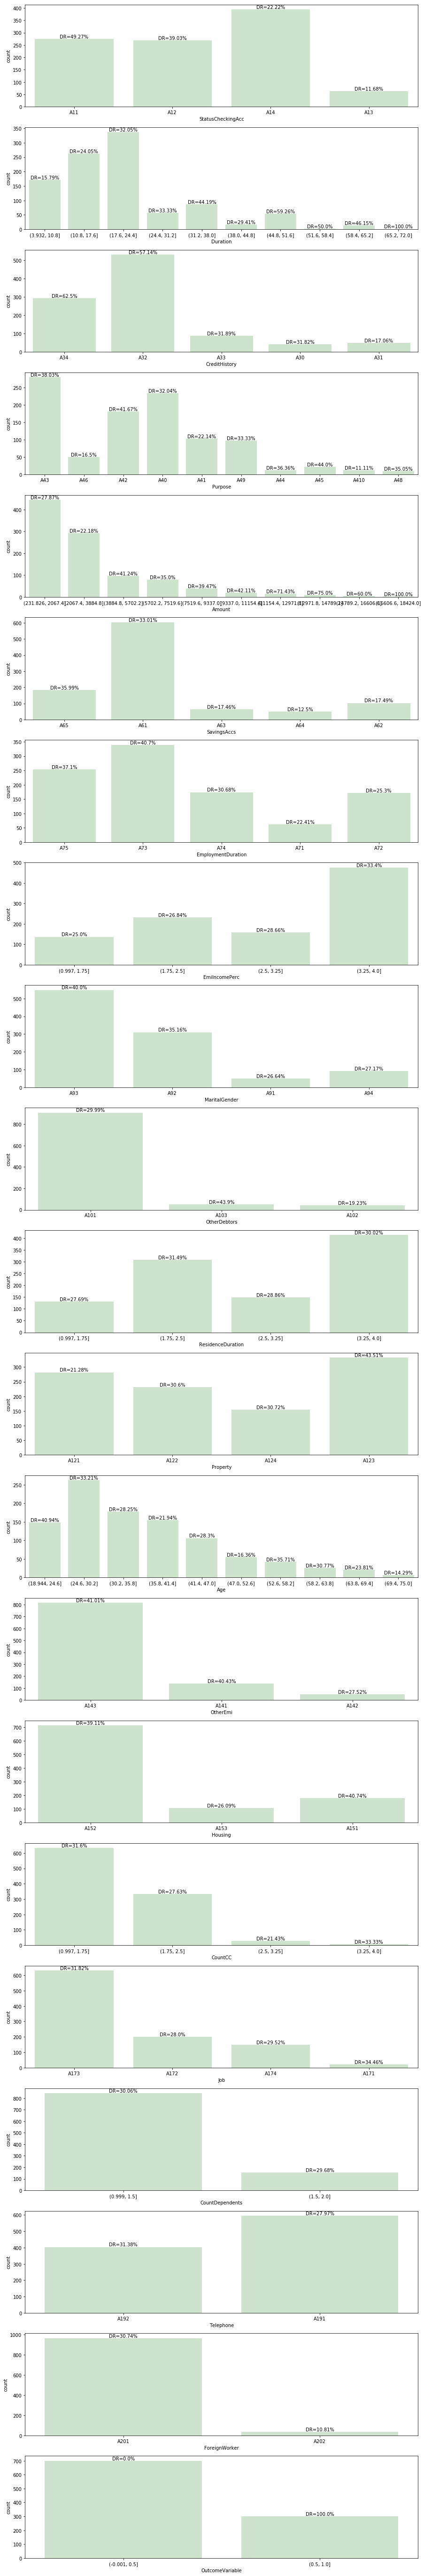

In [8]:
fig, ax = plt.subplots(21, 1, figsize=(15, 100))

for idx, col in enumerate(df.columns):
    if df[col].dtype == 'int64':
        sns.countplot(pd.cut(df[col], min(10, df[col].nunique())), ax=ax[idx], color='#c9e7ca')
        tmp = df.groupby(pd.cut(df[col], min(10, df[col].nunique()))).agg({'OutcomeVariable': ['sum', 'count']})
    else:
        sns.countplot(df[col], ax=ax[idx], color='#c9e7ca')
        tmp = df.groupby(col).agg({'OutcomeVariable': ['sum', 'count']})
    tmp['BadRate'] = round(100*tmp[('OutcomeVariable', 'sum')]/tmp[('OutcomeVariable', 'count')], 2)
    for p, label in zip(ax[idx].patches, tmp['BadRate'].values):
            ax[idx].annotate('DR='+str(label)+'%', (p.get_x() + p.get_width() / 2.0, p.get_height()), 
                             ha='center', va='bottom')
            
plt.show()

## Step 2C: Checking if Distribution of X variables changes for Default vs Non Default

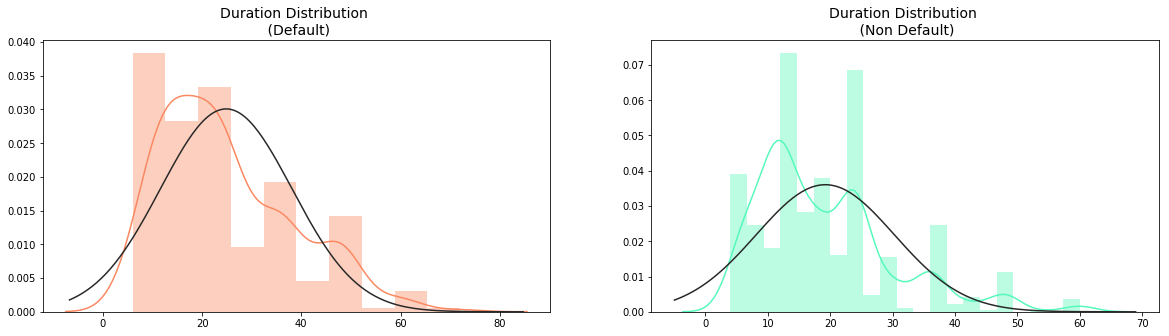

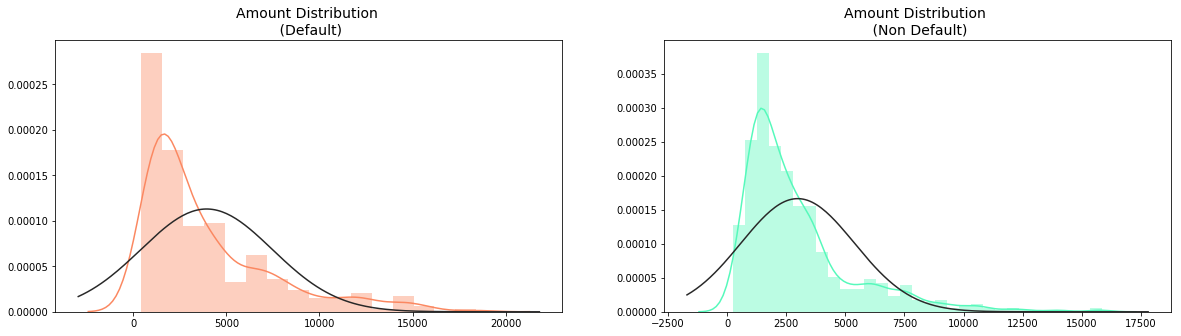

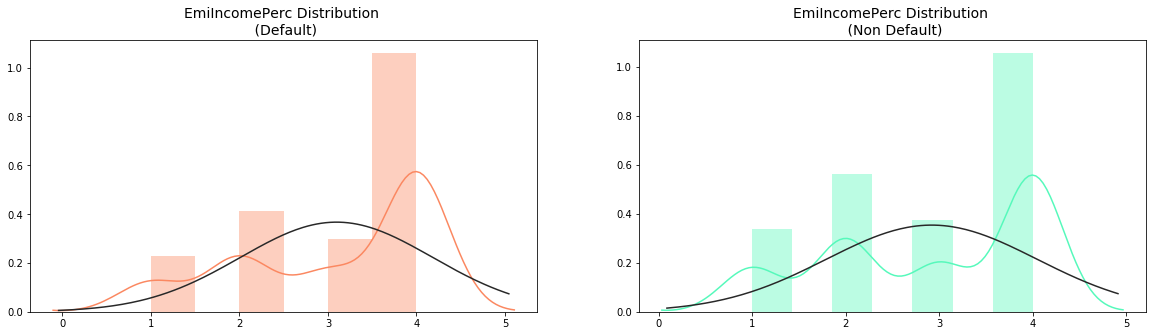

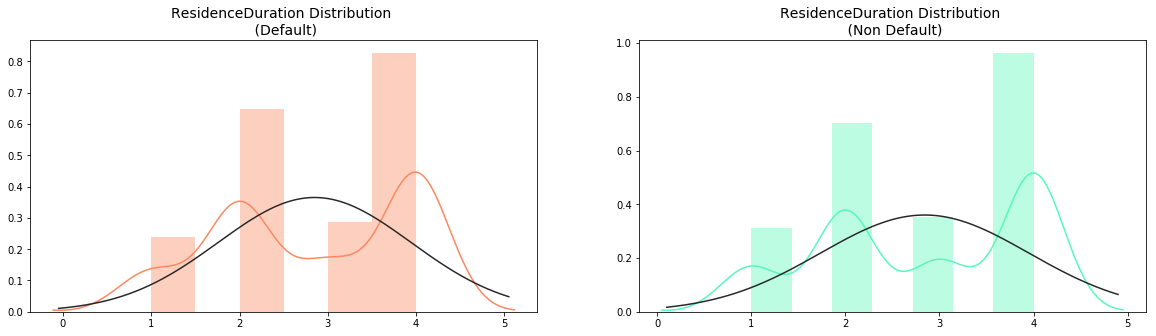

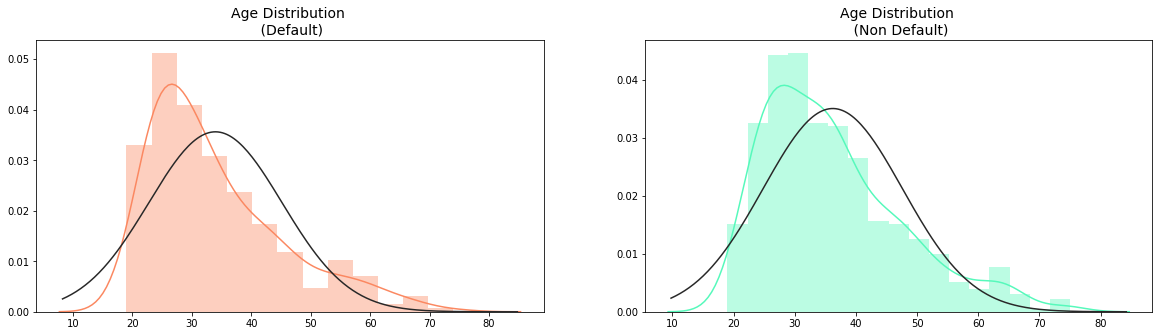

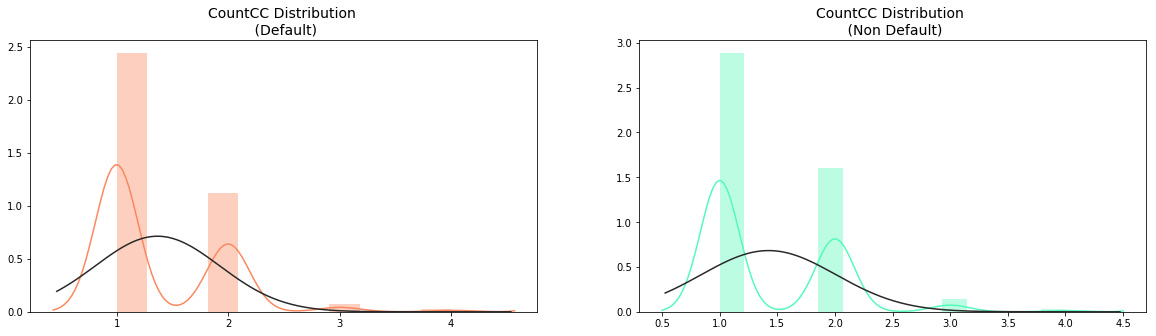

In [9]:
from scipy.stats import norm
for col in df.select_dtypes(include='int64').columns:
    if df[col].nunique() > 3:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

        default_dist = df[col].loc[df['OutcomeVariable'] == 1].values
        sns.distplot(default_dist, ax=ax1, fit=norm, color='#FB8861')
        ax1.set_title('{} Distribution \n (Default)'.format(col), fontsize=14)

        nondefault_dist = df[col].loc[df['OutcomeVariable'] == 0].values
        sns.distplot(nondefault_dist, ax=ax2, fit=norm, color='#56F9BB')
        ax2.set_title('{} Distribution \n (Non Default)'.format(col), fontsize=14)

        plt.show()

## Would a person with Critical credit history be more credit worthy?

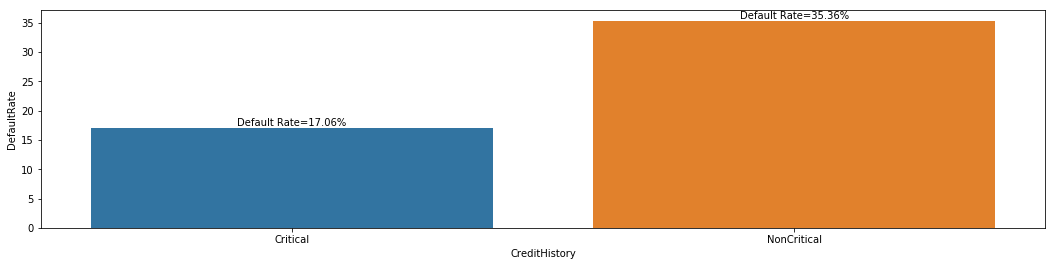

In [10]:
acc_critical = df[['CreditHistory', 'OutcomeVariable']]
acc_critical['CreditHistory'] = np.where(acc_critical['CreditHistory'] == 'A34', 'Critical', 'NonCritical')

freq = acc_critical.groupby('CreditHistory', 
                            as_index=False)['OutcomeVariable'].count().rename(columns={'OutcomeVariable': 'Total'})
defaults = acc_critical.groupby('CreditHistory', 
                                as_index=False)['OutcomeVariable'].sum().rename(columns={'OutcomeVariable': 'Defaults'})

acc_critical = pd.merge(freq, defaults, on='CreditHistory')
acc_critical['DefaultRate'] = 100*(acc_critical['Defaults']/acc_critical['Total'])

fig, ax = plt.subplots(figsize=(18, 4))
sns.barplot(x='CreditHistory', y='DefaultRate', data=acc_critical, ax=ax)
for p, label in zip(ax.patches, acc_critical['DefaultRate'].values):
    ax.annotate('Default Rate='+str(np.round(label, 2))+'%', 
                (p.get_x() + p.get_width() / 2.0, p.get_height()), ha='center', va='bottom')

#### It appears that the default rate for Critical category is much lesser than the rest - which could be due to banks allowing for only Secured lending to such borrowers - we will need to inspect the nature of loan to come up with a precise conclusion

## Would a young person (assumption: <= 30) be more credit worthy?

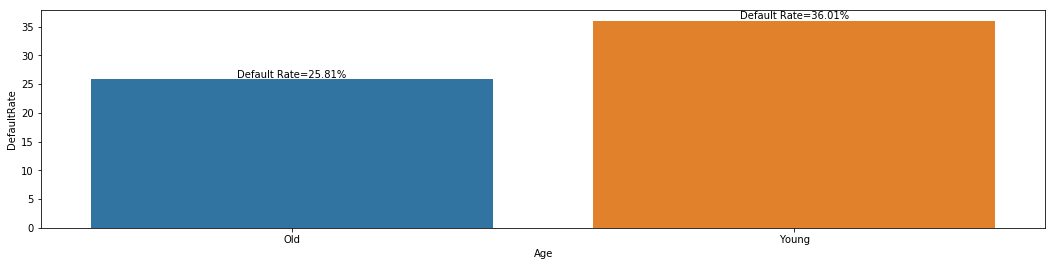

In [11]:
acc_young = df[['Age', 'OutcomeVariable']]
acc_young['Age'] = np.where(acc_young['Age'] <= 30, 'Young', 'Old')

freq = acc_young.groupby('Age', as_index=False)['OutcomeVariable'].count().rename(columns={'OutcomeVariable': 'Total'})
defaults = acc_young.groupby('Age', 
                             as_index=False)['OutcomeVariable'].sum().rename(columns={'OutcomeVariable': 'Defaults'})

acc_young = pd.merge(freq, defaults, on='Age')
acc_young['DefaultRate'] = 100*(acc_young['Defaults']/acc_young['Total'])

fig, ax = plt.subplots(figsize=(18, 4))
sns.barplot(x='Age', y='DefaultRate', data=acc_young, ax=ax)
for p, label in zip(ax.patches, acc_young['DefaultRate'].values):
    ax.annotate('Default Rate='+str(np.round(label, 2))+'%', 
                (p.get_x() + p.get_width() / 2.0, p.get_height()), ha='center', va='bottom')

#### It appears that the default rate for Young borrowers is higher than their older counterparts - which could be due to low income to spend ratio - they would in general be riskier borrowers

## Would a person with more Credit Accounts be more credit worthy?

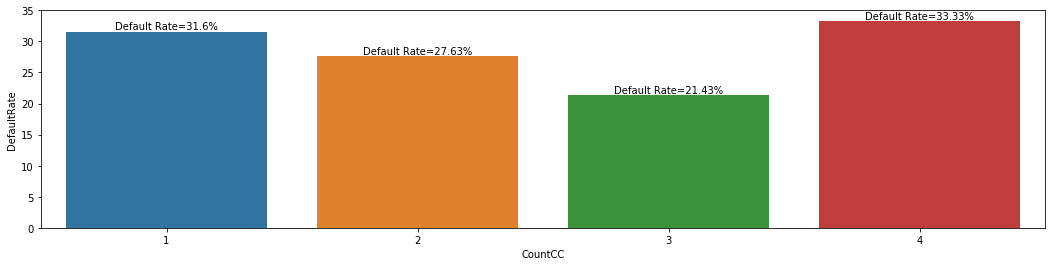

In [12]:
acc_credit = df[['CountCC', 'OutcomeVariable']]

freq = acc_credit.groupby('CountCC', as_index=False)['OutcomeVariable'].count().rename(columns={'OutcomeVariable': 'Total'})
defaults = acc_credit.groupby('CountCC', 
                              as_index=False)['OutcomeVariable'].sum().rename(columns={'OutcomeVariable': 'Defaults'})

acc_credit = pd.merge(freq, defaults, on='CountCC')
acc_credit['DefaultRate'] = 100*(acc_credit['Defaults']/acc_credit['Total'])

fig, ax = plt.subplots(figsize=(18, 4))
sns.barplot(x='CountCC', y='DefaultRate', data=acc_credit, ax=ax)
for p, label in zip(ax.patches, acc_credit['DefaultRate'].values):
    ax.annotate('Default Rate='+str(np.round(label, 2))+'%', 
                (p.get_x() + p.get_width() / 2.0, p.get_height()), ha='center', va='bottom')

#### Borrowers with higher number of exisitng tradelines with the bank are found to have lesser default rates. Since there are only 6 customers with 4 existing tradelines, we should count the increased deault rate for that bucket as an anamoly, with the general conclusion being that a person with higher Credit Accounts is more credit worthy

## Step 3A: Split dataset into train and test (80-20 split)

In [13]:
x_vars = ['StatusCheckingAcc', 'Duration', 'CreditHistory', 'Purpose', 'Amount', 'SavingsAccs', 'EmploymentDuration', 
          'EmiIncomePerc', 'MaritalGender', 'OtherDebtors', 'ResidenceDuration', 'Property', 'Age', 'OtherEmi', 'Housing',
          'CountCC', 'Job', 'CountDependents', 'Telephone', 'ForeignWorker']
y_var = 'OutcomeVariable'

X_train, X_test, Y_train, Y_test = train_test_split(df[x_vars], df[y_var], test_size=0.2, random_state=42)
print('We will build 2 sets of models:')
print('1. Training data is kept to original default ratio')
print('2. Training data is oversampled to bump default ratio to 50% - Done later in the code')

We will build 2 sets of models:
1. Training data is kept to original default ratio
2. Training data is oversampled to bump default ratio to 50% - Done later in the code


## Step 3B: Checking for VIF and IV for variable selection

In [14]:
def get_ivscore(df, x_col, y_col, ncuts=None):
    if ncuts is None:
        out = df.groupby(x_col).agg({y_col: ['sum', 'count']}) 
    else:
        out = df.groupby(pd.cut(df[x_col], min(ncuts, df[x_col].nunique()))).agg({y_col: ['sum', 'count']})
    out['#Events'] = out[(y_col, 'sum')]
    out['#NonEvents'] = out[(y_col, 'count')] - out[(y_col, 'sum')]
    out['%Events'] = out['#Events']/(out['#Events'].sum())
    out['%NonEvents'] = out['#NonEvents']/(out['#NonEvents'].sum())
    out['WOE'] = np.log(out['%Events']/out['%NonEvents'])
    out['%Diff'] = out['%Events'] - out['%NonEvents']
    out['IV'] = out['%Diff']*out['WOE']
    out.replace([np.inf, -np.inf], 0, inplace=True)
    out.drop(columns=[(y_col, 'sum'), (y_col, 'count')], inplace=True)
    return out, out['IV'].sum()

In [15]:
# Find IV scores, based on train for each X variable and replace categorical values with their IV scores for train & test

tmp_train = pd.concat([X_train, Y_train], axis=1)

iv_dict = {}
iv_map_dict = {}
for var in x_vars:
    if X_train[var].dtype == 'int64':
        tmp, iv = get_ivscore(tmp_train, var, y_var, 10)
    else:
        tmp, iv = get_ivscore(tmp_train, var, y_var, None)
        map_dict = {}
        for row in tmp.reset_index()[[var, 'IV']].values:
            map_dict[row[0]] = row[1]
        iv_map_dict[var] = map_dict
        X_train[var].replace(map_dict, inplace=True)
        X_test[var].replace(map_dict, inplace=True)
    iv_dict[var] = iv

    
iv_reverse_map_dict = {}
for key in iv_map_dict.keys():
    tmp_dict = {}
    for i_key in iv_map_dict[key]:
        tmp_dict[iv_map_dict[key][i_key]] = i_key
    iv_reverse_map_dict[key] = tmp_dict
    
    
iv_dict

{'StatusCheckingAcc': 0.5834368947049597,
 'Duration': 0.26054621103586645,
 'CreditHistory': 0.3314133205702201,
 'Purpose': 0.190174760099545,
 'Amount': 0.19116697653059753,
 'SavingsAccs': 0.14873235726500958,
 'EmploymentDuration': 0.07809221062806822,
 'EmiIncomePerc': 0.010046844311888608,
 'MaritalGender': 0.052032873859020355,
 'OtherDebtors': 0.012696629009606782,
 'ResidenceDuration': 0.013367105104874377,
 'Property': 0.1346432003201154,
 'Age': 0.14384867338672627,
 'OtherEmi': 0.056528603534396024,
 'Housing': 0.11873688194176815,
 'CountCC': 0.014458520460780267,
 'Job': 0.019055646072930206,
 'CountDependents': 0.00011925783131962112,
 'Telephone': 0.003962560287897623,
 'ForeignWorker': 0.04234872316987687}

In [16]:
print('Following variables appear to be strong predictors as per IV scores: StatusCheckingAcc, Duration, CreditHistory')
print('Following variables appear to be medium predictors as per IV scores: Purpose, Amount, SavingsAccs, Property, Age')

Following variables appear to be strong predictors as per IV scores: StatusCheckingAcc, Duration, CreditHistory
Following variables appear to be medium predictors as per IV scores: Purpose, Amount, SavingsAccs, Property, Age


In [17]:
vif = pd.DataFrame({'Variable': X_train[x_vars].columns})
vif['VIF'] = [variance_inflation_factor(X_train[x_vars].values, i) for i in range(X_train[x_vars].shape[1])]
vif.sort_values('VIF', ascending=False)

Variable        VIF
14             Housing  71.527338
18           Telephone  37.221696
12                 Age  13.241106
17     CountDependents  12.236364
5          SavingsAccs  11.572116
7        EmiIncomePerc   9.728370
10   ResidenceDuration   9.130169
15             CountCC   9.113071
8        MaritalGender   8.583226
1             Duration   7.852030
4               Amount   5.062409
0    StatusCheckingAcc   3.662500
3              Purpose   3.009638
13            OtherEmi   3.000948
6   EmploymentDuration   2.437757
2        CreditHistory   2.269077
11            Property   2.002565
16                 Job   1.646154
9         OtherDebtors   1.199256
19       ForeignWorker   1.168713

In [18]:
print('The following variables have high VIF and maybe dropped from our model: Housing, Telephone')

The following variables have high VIF and maybe dropped from our model: Housing, Telephone


#### Rebalancing the train dataset - using SMOTE

In [19]:
X_train_blncd, Y_train_blncd = SMOTE().fit_sample(X_train, Y_train)

In [20]:
x_vars_run1 = ['StatusCheckingAcc', 'Duration', 'CreditHistory', 'Purpose', 'Amount', 'SavingsAccs', 'Property', 'Age']

X_train = X_train[x_vars_run1]
X_train_blncd = X_train_blncd[x_vars_run1]

X_test = X_test[x_vars_run1]

## Step 3C: Model fitting using Grid Search with 3 fold cross validation

In [21]:
# Logistic Regression 
log_reg_params = {'penalty': ['l1', 'l2'], 
                  'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params, scoring='roc_auc', cv=3, n_jobs=-1)
grid_log_reg.fit(X_train, Y_train)
# Logistic best estimator
log_reg = grid_log_reg.best_estimator_
print('AUC on test data for Unbalanced Logistic = {}'.format(roc_auc_score(Y_test, log_reg.predict_proba(X_test)[:, 1])))

# DecisionTree Classifier
dt_params = {'max_features': ['auto', 'sqrt'],
             'max_depth': [2, 5, 15],
             'min_samples_leaf': [1, 10, 50]}
grid_dt = GridSearchCV(DecisionTreeClassifier(), dt_params, scoring='roc_auc', cv=3, n_jobs=-1)
grid_dt.fit(X_train, Y_train)
# DecisionTree best model
dt = grid_dt.best_estimator_
print('AUC on test data for Unbalanced DecisionTree = {}'.format(roc_auc_score(Y_test, dt.predict_proba(X_test)[:, 1])))

# RandomForest Classifier
rf_params = {'n_estimators': [100, 500],
             'max_features': ['auto', 'sqrt'],
             'max_depth': [2, 5, 15],
             'min_samples_leaf': [1, 10, 50]}
grid_rf = GridSearchCV(RandomForestClassifier(), rf_params, scoring='roc_auc', cv=3, n_jobs=-1)
grid_rf.fit(X_train, Y_train)
# RandomForest best model
rf_clf = grid_rf.best_estimator_
print('AUC on test data for Unbalanced RandomForest = {}'.format(roc_auc_score(Y_test, rf_clf.predict_proba(X_test)[:, 1])))

AUC on test data for Unbalanced Logistic = 0.511479745161678
AUC on test data for Unbalanced DecisionTree = 0.6634811876427456
AUC on test data for Unbalanced RandomForest = 0.8151220098569539


In [22]:
# Logistic Regression trained on SMOTE data
log_reg_params = {'penalty': ['l1', 'l2'], 
                  'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_log_reg_blncd = GridSearchCV(LogisticRegression(), log_reg_params, scoring='roc_auc', cv=3, n_jobs=-1)
grid_log_reg_blncd.fit(X_train_blncd, Y_train_blncd)
# Logistic best estimator trained on SMOTE data
log_reg_blncd = grid_log_reg_blncd.best_estimator_
print('AUC on test data for Balanced Logistic = {}'.format(roc_auc_score(Y_test, 
                                                                         log_reg_blncd.predict_proba(X_test)[:, 1])))

# DecisionTree Classifier
dt_params = {'max_features': ['auto', 'sqrt'],
             'max_depth': [2, 5, 15],
             'min_samples_leaf': [1, 10, 50]}
grid_dt_blncd = GridSearchCV(DecisionTreeClassifier(), dt_params, scoring='roc_auc', cv=3, n_jobs=-1)
grid_dt_blncd.fit(X_train_blncd, Y_train_blncd)
# DecisionTree best model
dt_blncd = grid_dt_blncd.best_estimator_
print('AUC on test data for Balanced DecisionTree = {}'.format(roc_auc_score(Y_test, dt_blncd.predict_proba(X_test)[:, 1])))

# Randomforest Classifier trained on SMOTE data
rf_params = {'n_estimators': [100, 500],
             'max_features': ['auto', 'sqrt'],
             'max_depth': [2, 5, 15],
             'min_samples_leaf': [1, 10, 50]}
grid_rf_blncd = GridSearchCV(RandomForestClassifier(), rf_params, scoring='roc_auc', cv=3, n_jobs=-1)
grid_rf_blncd.fit(X_train_blncd, Y_train_blncd)
# RandomForest best model trained on SMOTE data
rf_clf_blncd = grid_rf_blncd.best_estimator_
print('AUC on test data for Balanced RandomForest = {}'.format(roc_auc_score(Y_test, 
                                                                             rf_clf_blncd.predict_proba(X_test)[:, 1])))

AUC on test data for Balanced Logistic = 0.6489962735905758
AUC on test data for Balanced DecisionTree = 0.712645750691189
AUC on test data for Balanced RandomForest = 0.7948070681572306


### Assuming no specific bias towards Logistic Regression - which is often the go to model in Credit Risk due to it's easy explainability, we'll choose the RandomForest model trained on the Unbalanced dataset as it gives the highest AUC

In [23]:
final_model = rf_clf

In [24]:
# Variable Importance Scores
var_imp = pd.DataFrame(zip(X_train.columns, final_model.feature_importances_))
var_imp.columns = ['Variable', 'Variable Importance Score']
var_imp.sort_values('Variable Importance Score', ascending=False)

Variable  Variable Importance Score
0  StatusCheckingAcc                   0.240964
4             Amount                   0.188712
1           Duration                   0.143977
7                Age                   0.140303
2      CreditHistory                   0.102166
3            Purpose                   0.088049
6           Property                   0.056330
5        SavingsAccs                   0.039500

In [25]:
print('Top 3 variables as per the model are:')
print('1. StatusCheckingAcc')
print('2. Amount')
print('3. Duration')

Top 3 variables as per the model are:
1. StatusCheckingAcc
2. Amount
3. Duration


## Step 3D: Find Ideal borrower

In [26]:
options_dict = {}
for col in X_train.columns:
    if X_train[col].nunique() <= 5:
        options_dict[col] = X_train[col].unique()
    else:
        options_dict[col] = X_train[col].describe()[['min', '25%', '50%', '75%', 'max']].values

In [27]:
combinations = pd.DataFrame(list(itertools.product(*[options_dict[i] for i in X_train.columns])))
combinations.columns = X_train.columns

In [28]:
pred_combinations = pd.DataFrame(final_model.predict_proba(combinations))
pred_combinations.columns = ['PredProba_0', 'PredProba_1']
pred_combinations = pred_combinations[pred_combinations['PredProba_1'] == pred_combinations['PredProba_1'].min()]

ideal_borrower = combinations.iloc[[pred_combinations.index.values[0]]]

In [29]:
ideal_borrower

StatusCheckingAcc  Duration  CreditHistory   Purpose  Amount  \
129119           0.332867       4.0       0.143641  0.062082  1380.0   

        SavingsAccs  Property   Age  
129119     0.030765  0.072082  75.0

In [30]:
print('The ideal borrower with a probability of default = {}% is expected to have the following characteristics:'.format(np.round(100*pred_combinations['PredProba_1'].min(), 2)))
for col in ideal_borrower.columns:
    if col in iv_reverse_map_dict.keys():
        value = iv_reverse_map_dict[col][ideal_borrower[col].values[0]]
    else:
        value = ideal_borrower[col].values[0]
    print('{0} = {1}'.format(col, value))

The ideal borrower with a probability of default = 1.76% is expected to have the following characteristics:
StatusCheckingAcc = A14
Duration = 4.0
CreditHistory = A34
Purpose = A43
Amount = 1380.0
SavingsAccs = A61
Property = A121
Age = 75.0


## Step 4A: Choose optimal cutoff to minimize weighed error rate

In [31]:
for cutoff in range(5, 101, 5):
    pred = [1 if i > cutoff/100.0 else 0 for i in final_model.predict_proba(X_test)[:, 1]] 
    fp = confusion_matrix(Y_test, pred)[0][1]
    fn = confusion_matrix(Y_test, pred)[1][0]
    weighed_error = (5*fn) + fp
    print('Weighed error count with cutoff set at {0} is {1}'.format(cutoff/100.0, weighed_error))

Weighed error count with cutoff set at 0.05 is 139
Weighed error count with cutoff set at 0.1 is 120
Weighed error count with cutoff set at 0.15 is 122
Weighed error count with cutoff set at 0.2 is 110
Weighed error count with cutoff set at 0.25 is 96
Weighed error count with cutoff set at 0.3 is 99
Weighed error count with cutoff set at 0.35 is 115
Weighed error count with cutoff set at 0.4 is 145
Weighed error count with cutoff set at 0.45 is 182
Weighed error count with cutoff set at 0.5 is 216
Weighed error count with cutoff set at 0.55 is 247
Weighed error count with cutoff set at 0.6 is 267
Weighed error count with cutoff set at 0.65 is 281
Weighed error count with cutoff set at 0.7 is 290
Weighed error count with cutoff set at 0.75 is 295
Weighed error count with cutoff set at 0.8 is 295
Weighed error count with cutoff set at 0.85 is 295
Weighed error count with cutoff set at 0.9 is 295
Weighed error count with cutoff set at 0.95 is 295
Weighed error count with cutoff set at 1.0

In [32]:
print('Setting cutoff at 0.45')

Setting cutoff at 0.45


## Step 4B: Model Performance KPIs

In [33]:
pred = [1 if i > 0.45 else 0 for i in final_model.predict_proba(X_test)[:, 1]] 
print('GINI = {}'.format(np.round(2*roc_auc_score(Y_test, rf_clf_blncd.predict_proba(X_test)[:, 1]) - 1, 2)))
print('F1 Score = {}'.format(np.round(f1_score(Y_test, pred), 2)))
print('Precision Score = {}'.format(np.round(precision_score(Y_test, pred), 2)))
print('Recall Score = {}'.format(np.round(recall_score(Y_test, pred), 2)))
print('Accuracy Score = {}'.format(np.round(accuracy_score(Y_test, pred), 2)))

GINI = 0.59
F1 Score = 0.52
Precision Score = 0.68
Recall Score = 0.42
Accuracy Score = 0.77
